In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras as keras 
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.constraints import max_norm
from keras.regularizers import L2
import tensorflow as tf
#import tensorflow_datasets as tfds
import scipy
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters
K.clear_session() ## needed???
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32

### ???
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
### import svhn_cropped without grayscale

# Open the file as readonly
h5f = h5py.File('SVHN_cropped.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_extra = h5f['X_extra'][:]
Y_extra = h5f['y_extra'][:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_extra = X_extra.astype('float32')

#### make validation set from train and extra (and make extra part of train(?))

X_train=np.append(X_train,X_extra, axis=0)
Y_train=np.append(Y_train,Y_extra, axis=0)
## normalising
sigma=np.std(X_train)
X_train /= sigma 
X_test /= sigma


mu=np.mean(X_train)
X_train -= mu
X_test -= mu





print('mean, variance', mu, sigma)
print("---------------Load SVHN----------------")
print('Training set', X_train.shape, Y_train.shape)
#print('Extra set', X_extra.shape, Y_extra.shape)
print('Test set', X_test.shape, Y_test.shape)

mean, variance 2.1985865 50.549427
---------------Load SVHN----------------
Training set (604388, 32, 32, 3) (604388, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [3]:
'''
## import svhn_cropped which is svhn in 32x32 size
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
# Open the file as readonly
h5f = h5py.File('SVHN_gray.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
Y_val = h5f['y_val'][:]

# Close this file
h5f.close()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test = x_test.astype('float32')
## normalising
#_train[:,axis=3] /= 255.0 
#X_test /= 255.0
#X_val /= 255.0

print('Training set', X_train.shape, Y_train.shape)
print('Validation set', X_val.shape, Y_val.shape)
print('Test set', X_test.shape, Y_test.shape)
'''

"\n## import svhn_cropped which is svhn in 32x32 size\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n# Open the file as readonly\nh5f = h5py.File('SVHN_gray.h5', 'r')\n\n# Load the training, test and validation set\nX_train = h5f['X_train'][:]\nY_train = h5f['y_train'][:]\nX_test = h5f['X_test'][:]\nY_test = h5f['y_test'][:]\nX_val = h5f['X_val'][:]\nY_val = h5f['y_val'][:]\n\n# Close this file\nh5f.close()\n\nx_train = x_train.astype('float32')\nx_test = x_test.astype('float32')\nx_test = x_test.astype('float32')\n## normalising\n#_train[:,axis=3] /= 255.0 \n#X_test /= 255.0\n#X_val /= 255.0\n\nprint('Training set', X_train.shape, Y_train.shape)\nprint('Validation set', X_val.shape, Y_val.shape)\nprint('Test set', X_test.shape, Y_test.shape)\n"

In [4]:
## import mnist
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()
x_train = np.pad(x_train,((0,0),(2,2),(2,2))) #padding to make images 32x32 and not 28x28
x_test = np.pad(x_test,((0,0),(2,2),(2,2))) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## normalising
#x_train /= 255.0 
#x_test /= 255.0

## normalising to unit variance
sigma=np.std(x_train)
x_train /= sigma 
x_test /= sigma

## mean subtraction
mu=np.mean(x_train)
x_train -= mu
x_test -= mu
## make labels into categorical classes
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)


x_train=np.expand_dims(x_train,3)
x_test=np.expand_dims(x_test,3)


### make mnist into 3 channels
x_train=np.concatenate((x_train,)*3, axis=-1)
x_test=np.concatenate((x_test,)*3, axis=-1)
print('mean, variance', mu, sigma)
print("---------------Load MNIST----------------")
print('Training set', x_train.shape, y_train.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test.shape, y_test.shape)


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [5]:

### load MNIST-M

h5f = h5py.File('MNIST-M.h5', 'r')

# Load the training, test and 
x_train_m = h5f['x_train'][:]
y_train_m = h5f['y_train'][:]
x_test_m = h5f['x_test'][:]
y_test_m = h5f['y_test'][:]


# Close this file
h5f.close()


x_train_m = x_train_m.astype('float32')
x_test_m = x_test_m.astype('float32')
## normalising to unit variance
sigma=np.std(x_train_m)
x_train_m /= sigma 
x_test_m /= sigma

## mean subtraction
mu=np.mean(x_train_m)
x_train_m -= mu
x_test_m -= mu

print('mean, variance', mu, sigma)
print("---------------Load MNIST-M----------------")
print('Training set', x_train_m.shape, y_train_m.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test_m.shape, y_test_m.shape)

mean, variance 1.7673833 63.87996
---------------Load MNIST-M----------------
Training set (59001, 32, 32, 3) (59001, 10)
Test set (9001, 32, 32, 3) (9001, 10)


In [6]:
########## preprocessing for mnist and svhn




#print(X_test)
#print("----------------------------------------------------")
#print(x_test)


#plt.imshow(X_test[303]) 
#print(Y_test[303])
#plt.imshow(x_test[303]) 
#print(y_test[303])

In [7]:
## implement LeNet-5 architecture
def init_model():
    model = Sequential()
    model.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(Flatten())
    #model.add(Dense(120, activation='tanh'))  #equivalent to the last conv2d above?
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [8]:
## implement LeNet-5-like architecture
def init_SVHN_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3),kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 6 5x5 conv kernels
    model.add(Dropout(0.9))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 16 5x5 conv kernels
    model.add(Dropout(0.75))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(128,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(3072, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) # output layer
    
    return model

'''
We use stochastic gradient descent with
momentum: 0.9
weight_decay: 0.0005
------ this was not used on mnist<->svhn tests
and the learning rate annealing described by the following formula:
µp =µ0/(1 + α · p)^β,
where p is the training progress linearly changing from 0
to 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule
was optimized to promote convergence and low error on
the source domain).
------

Following (Srivastava et al., 2014) we also use dropout and
l_2-norm restriction when we train the SVHN architecture.
'''

'\nWe use stochastic gradient descent with\nmomentum: 0.9\nweight_decay: 0.0005\n------ this was not used on mnist<->svhn tests\nand the learning rate annealing described by the following formula:\nµp =µ0/(1 + α · p)^β,\nwhere p is the training progress linearly changing from 0\nto 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule\nwas optimized to promote convergence and low error on\nthe source domain).\n------\n\nFollowing (Srivastava et al., 2014) we also use dropout and\nl_2-norm restriction when we train the SVHN architecture.\n'

In [9]:
## implement LeNet-5-like architecture
def init_MNIST_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Conv2D(48,(5,5),strides=(1,1), activation='relu')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [10]:
## shamelessly taken from : https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras

## Custom callback to be able to evaluate and save the results from several validation sets during training
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i].name
                self.history.setdefault(valuename, []).append(result)

In [11]:
def train_model(model="SVHN" ,batch_size=128 ,total_epochs=25 ,iterations=1 ,x_train=[] ,y_train=[] ,x_test=[] ,y_test=[] ,x_target=[] ,y_target=[]):
    history = AdditionalValidationSets([(x_target, y_target, 'target_val')])
    histories=[]
    M=init_SVHN_model()
    for i in range(iterations):
        if model=="SVHN":
            M=init_SVHN_model()
        elif model=="MNIST":
            M=init_MNIST_model()
        elif model=="MNIST-M":
            M=init_MNIST_model()
        elif model=="2MNIST-M":
            M=init_MNIST_model()
        
        ## choose loss function, optimiser etc. and train
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                      metrics=['accuracy'],)

        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history])
        histories.append(history.history)
    return histories

In [12]:
def plot_results(total_epochs,model="SVHN",result=[], xlabel="Epoch"):#,ylabel="", title=""): 
    ### TODO: do one for each type of plot?
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()

    #print("now =", now)

    # dd/mm/YY H:M
    dt_string = now.strftime("%d%m%Y_%H:%M")
    #print("date and time =", dt_string)
    
    ## plotting and saving to disk
    x=[i+1 for i in range(total_epochs)]

    if model=="SVHN":
        prefix=["S2MACC","S2MVAL","S2MLOSS","S2MVALLOSS"]
    elif model=="MNIST":
        prefix=["M2SACC","M2SVAL","M2SLOSS","M2SVALLOSS"]
    elif model=="MNIST-M":
         prefix=["MM2MACC","MM2MVAL","MM2MLOSS","MM2MVALLOSS"]
    elif model=="2MNIST-M":
        prefix=["M2MMACC","M2MMVAL","M2MMLOSS","M2MMVALLOSS"]

    f, ax = plt.subplots()
    ax.plot(x,result['target_val_accuracy'], '*-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Target acc'], loc = 0)
    ax.set_title('Target acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    f.savefig("./images/"+prefix[0]+dt_string+".pdf")
   

    f, ax = plt.subplots()
    ax.plot(x,result['val_accuracy'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Validation acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    f.savefig("./images/"+prefix[1]+dt_string+".pdf")

    f, ax = plt.subplots()
    
    ax.plot(x,result['loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Training loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    f.savefig("./images/"+prefix[2]+dt_string+".pdf")

    f, ax = plt.subplots()
    ax.plot(x,result['val_loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Validation loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    f.savefig("./images/"+prefix[3]+dt_string+".pdf")

Epoch 1/200
4722/4722 [==============================] - 44s 9ms/step - loss: 2.9230 - accuracy: 0.3774 - val_loss: 1.7840 - val_accuracy: 0.7533
Epoch 2/200
4722/4722 [==============================] - 40s 8ms/step - loss: 1.4382 - accuracy: 0.7342 - val_loss: 1.5153 - val_accuracy: 0.7614
Epoch 3/200
4722/4722 [==============================] - 41s 9ms/step - loss: 1.0933 - accuracy: 0.7794 - val_loss: 1.2616 - val_accuracy: 0.7719
Epoch 4/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.9502 - accuracy: 0.8006 - val_loss: 1.2070 - val_accuracy: 0.7793
Epoch 5/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.8906 - accuracy: 0.8111 - val_loss: 1.0878 - val_accuracy: 0.8182
Epoch 6/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.8558 - accuracy: 0.8192 - val_loss: 1.0404 - val_accuracy: 0.8453
Epoch 7/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.8380 - accuracy: 0.8247 - val_loss: 1.0904 -

Epoch 57/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7929 - accuracy: 0.8395 - val_loss: 0.9409 - val_accuracy: 0.8168
Epoch 58/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7902 - accuracy: 0.8403 - val_loss: 0.9072 - val_accuracy: 0.8593
Epoch 59/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7918 - accuracy: 0.8399 - val_loss: 0.9013 - val_accuracy: 0.8675
Epoch 60/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7889 - accuracy: 0.8397 - val_loss: 0.8958 - val_accuracy: 0.8699
Epoch 61/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7900 - accuracy: 0.8404 - val_loss: 0.9255 - val_accuracy: 0.8516
Epoch 62/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7893 - accuracy: 0.8411 - val_loss: 0.9440 - val_accuracy: 0.8438
Epoch 63/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7874 - accuracy: 0.8405 - val_loss: 0

4722/4722 [==============================] - 41s 9ms/step - loss: 0.7865 - accuracy: 0.8422 - val_loss: 0.9024 - val_accuracy: 0.8714
Epoch 113/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7899 - accuracy: 0.8412 - val_loss: 0.8876 - val_accuracy: 0.8621
Epoch 114/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7862 - accuracy: 0.8422 - val_loss: 0.8865 - val_accuracy: 0.8692
Epoch 115/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7874 - accuracy: 0.8418 - val_loss: 0.9330 - val_accuracy: 0.8703
Epoch 116/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7883 - accuracy: 0.8417 - val_loss: 0.8937 - val_accuracy: 0.8594
Epoch 117/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7885 - accuracy: 0.8417 - val_loss: 0.9191 - val_accuracy: 0.8657
Epoch 118/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7878 - accuracy: 0.8413 - val_loss: 0.9139 -

4722/4722 [==============================] - 41s 9ms/step - loss: 0.7856 - accuracy: 0.8422 - val_loss: 0.8686 - val_accuracy: 0.8700
Epoch 168/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7873 - accuracy: 0.8420 - val_loss: 0.9053 - val_accuracy: 0.8647
Epoch 169/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7852 - accuracy: 0.8426 - val_loss: 0.9096 - val_accuracy: 0.8655
Epoch 170/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7879 - accuracy: 0.8425 - val_loss: 0.9209 - val_accuracy: 0.8704
Epoch 171/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7899 - accuracy: 0.8413 - val_loss: 0.9104 - val_accuracy: 0.8606
Epoch 172/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7834 - accuracy: 0.8430 - val_loss: 0.8741 - val_accuracy: 0.8523
Epoch 173/200
4722/4722 [==============================] - 41s 9ms/step - loss: 0.7839 - accuracy: 0.8426 - val_loss: 0.8941 -

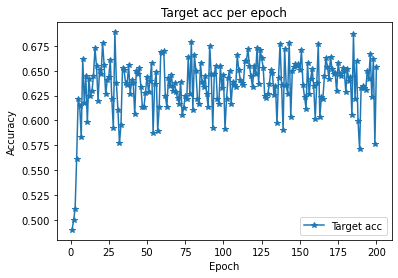

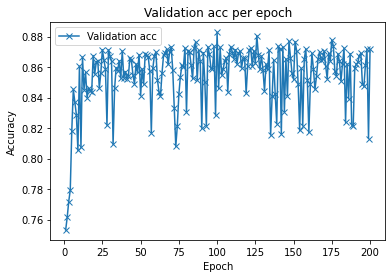

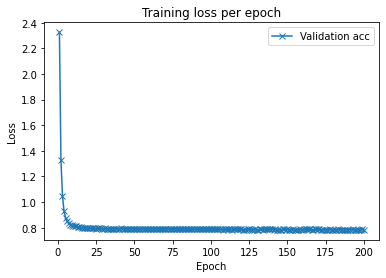

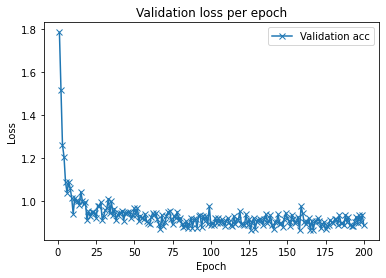

In [13]:
### test for SVHN-> MNIST, 
total_epochs=200 #


iterations=5
histories=[]

#histories=train_model(model="SVHN",total_epochs=total_epochs,iterations=iterations,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
    
histories=train_model(total_epochs=total_epochs,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="SVHN",result=result,xlabel="Epoch",total_epochs=total_epochs)

Epoch 1/1000
469/469 [==============================] - 2s 4ms/step - loss: 0.7514 - accuracy: 0.7666 - val_loss: 0.0796 - val_accuracy: 0.9732
Epoch 2/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0805 - accuracy: 0.9749 - val_loss: 0.0616 - val_accuracy: 0.9810
Epoch 3/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0571 - accuracy: 0.9827 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 4/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0440 - accuracy: 0.9860 - val_loss: 0.0555 - val_accuracy: 0.9816
Epoch 5/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.0320 - val_accuracy: 0.9901
Epoch 6/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0294 - accuracy: 0.9911 - val_loss: 0.0359 - val_accuracy: 0.9878
Epoch 7/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0304 - val_accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.7517e-04 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9921
Epoch 58/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7999e-04 - accuracy: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9918
Epoch 59/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0352 - val_accuracy: 0.9923
Epoch 60/1000
469/469 [==============================] - 2s 3ms/step - loss: 9.5917e-04 - accuracy: 0.9998 - val_loss: 0.0327 - val_accuracy: 0.9916
Epoch 61/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5253e-04 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9923
Epoch 62/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0628e-04 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 0.9927
Epoch 63/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8990e-04 - accuracy: 1.0000 - val_loss: 0.032

469/469 [==============================] - 2s 3ms/step - loss: 2.6054e-05 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9926
Epoch 113/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.0942e-05 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9924
Epoch 114/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9088e-05 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9924
Epoch 115/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6565e-05 - accuracy: 1.0000 - val_loss: 0.0400 - val_accuracy: 0.9923
Epoch 116/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6368e-05 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9923
Epoch 117/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.0105e-05 - accuracy: 1.0000 - val_loss: 0.0400 - val_accuracy: 0.9923
Epoch 118/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6662e-05 - accuracy: 1.0000 - val_l

Epoch 167/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7280e-05 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 0.9921
Epoch 168/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5850e-05 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9922
Epoch 169/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5406e-05 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 0.9922
Epoch 170/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5497e-05 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 0.9921
Epoch 171/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5812e-05 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9921
Epoch 172/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5901e-05 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9921
Epoch 173/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.3829e-05 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.2316e-05 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9920
Epoch 222/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.2015e-05 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9920
Epoch 223/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.1600e-05 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9921
Epoch 224/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.0860e-05 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9921
Epoch 225/1000
469/469 [==============================] - 2s 3ms/step - loss: 9.8854e-06 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9922
Epoch 226/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.0305e-05 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9921
Epoch 227/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.1352e-05 - accuracy: 1.0000 - val_l

Epoch 276/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.5666e-06 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 0.9920
Epoch 277/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.3436e-06 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 0.9920
Epoch 278/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.2182e-06 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9920
Epoch 279/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.2523e-06 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9920
Epoch 280/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.7599e-06 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9920
Epoch 281/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.9410e-06 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9920
Epoch 282/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.2890e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 7.0437e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9920
Epoch 331/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.4899e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9920
Epoch 332/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.4384e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9919
Epoch 333/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.1995e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9921
Epoch 334/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.4982e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9920
Epoch 335/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.3568e-06 - accuracy: 1.0000 - val_loss: 0.0474 - val_accuracy: 0.9920
Epoch 336/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.4008e-06 - accuracy: 1.0000 - val_l

Epoch 385/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.9831e-06 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9921
Epoch 386/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.1377e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9919
Epoch 387/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.0974e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9920
Epoch 388/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.3069e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9921
Epoch 389/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.7827e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9920
Epoch 390/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.1282e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9920
Epoch 391/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.3753e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 4.5888e-06 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9920
Epoch 440/1000
469/469 [==============================] - 2s 4ms/step - loss: 4.0973e-06 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9919
Epoch 441/1000
469/469 [==============================] - 2s 4ms/step - loss: 4.7571e-06 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9920
Epoch 442/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.3658e-06 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9919
Epoch 443/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.6596e-06 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9920
Epoch 444/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.9509e-06 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9920
Epoch 445/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.4256e-06 - accuracy: 1.0000 - val_l

Epoch 494/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.8117e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9920
Epoch 495/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.7639e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9920
Epoch 496/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.6976e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9920
Epoch 497/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.9396e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9919
Epoch 498/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.8183e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9920
Epoch 499/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.8529e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9920
Epoch 500/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.7731e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 3.5580e-06 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9920
Epoch 549/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2193e-06 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9920
Epoch 550/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.1579e-06 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9919
Epoch 551/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2686e-06 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9920
Epoch 552/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.6610e-06 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9920
Epoch 553/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.3882e-06 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9920
Epoch 554/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.6353e-06 - accuracy: 1.0000 - val_l

Epoch 603/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.1911e-06 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9920
Epoch 604/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7824e-06 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9920
Epoch 605/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2627e-06 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9920
Epoch 606/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.0822e-06 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9920
Epoch 607/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9133e-06 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9920
Epoch 608/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9288e-06 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9920
Epoch 609/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9627e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 2.5577e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9920
Epoch 658/1000
469/469 [==============================] - 2s 4ms/step - loss: 2.3632e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9920
Epoch 659/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9765e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9921
Epoch 660/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4143e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9921
Epoch 661/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.8205e-06 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9920
Epoch 662/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7766e-06 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9920
Epoch 663/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7202e-06 - accuracy: 1.0000 - val_l

Epoch 712/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5433e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 713/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4782e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 714/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6861e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 715/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6045e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 716/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4048e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 717/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4989e-06 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 718/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5910e-06 - accuracy:

469/469 [==============================] - 2s 4ms/step - loss: 2.2023e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9921
Epoch 767/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0393e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9921
Epoch 768/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.1840e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9921
Epoch 769/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0531e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9921
Epoch 770/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3202e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9921
Epoch 771/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0708e-06 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9921
Epoch 772/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2879e-06 - accuracy: 1.0000 - val_l

Epoch 821/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8926e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 822/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3389e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 823/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8922e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 824/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.1984e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 825/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.1000e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 826/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2696e-06 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9921
Epoch 827/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9745e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.8670e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 876/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0004e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 877/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8114e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 878/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9696e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 879/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0630e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 880/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7442e-06 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9921
Epoch 881/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9405e-06 - accuracy: 1.0000 - val_l

Epoch 930/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7495e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 931/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6727e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 932/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8203e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 933/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6571e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 934/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7464e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 935/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6702e-06 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 936/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6355e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.5863e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 985/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0014e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 986/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5300e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 987/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7831e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 988/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7100e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 989/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6579e-06 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9921
Epoch 990/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5664e-06 - accuracy: 1.0000 - val_l

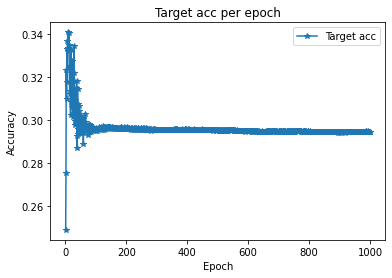

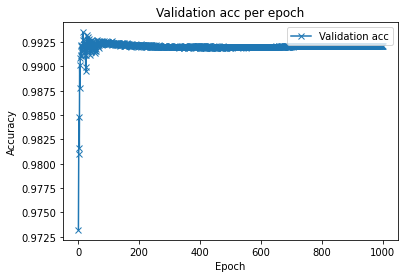

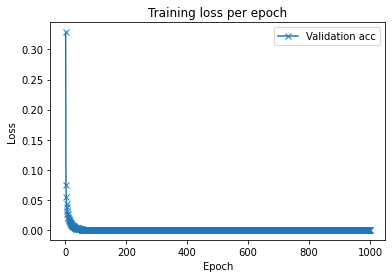

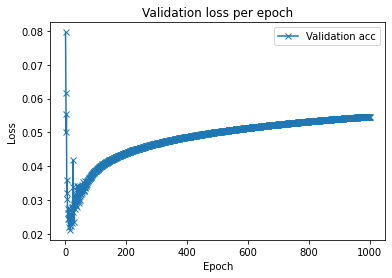

In [14]:
### test for MNIST->SVHN
total_epochs=1000 #


iterations=5
histories=[]


    
histories=train_model(model="MNIST",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=X_test,y_target=Y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST",result=result,xlabel="Epoch",total_epochs=total_epochs)

Epoch 1/1000
461/461 [==============================] - 2s 4ms/step - loss: 1.4509 - accuracy: 0.5038 - val_loss: 0.3275 - val_accuracy: 0.8985
Epoch 2/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.2988 - accuracy: 0.9100 - val_loss: 0.2290 - val_accuracy: 0.9299
Epoch 3/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.2007 - accuracy: 0.9379 - val_loss: 0.1632 - val_accuracy: 0.9495
Epoch 4/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.1563 - accuracy: 0.9512 - val_loss: 0.1499 - val_accuracy: 0.9548
Epoch 5/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.1267 - accuracy: 0.9597 - val_loss: 0.1383 - val_accuracy: 0.9566
Epoch 6/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.1142 - accuracy: 0.9637 - val_loss: 0.1373 - val_accuracy: 0.9579
Epoch 7/1000
461/461 [==============================] - 2s 3ms/step - loss: 0.1010 - accuracy: 0.9678 - val_loss: 0.1209 - val_accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 1.6282e-04 - accuracy: 1.0000 - val_loss: 0.2177 - val_accuracy: 0.9700
Epoch 58/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.4643e-04 - accuracy: 1.0000 - val_loss: 0.2190 - val_accuracy: 0.9699
Epoch 59/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.4607e-04 - accuracy: 1.0000 - val_loss: 0.2205 - val_accuracy: 0.9697
Epoch 60/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.4596e-04 - accuracy: 1.0000 - val_loss: 0.2210 - val_accuracy: 0.9697
Epoch 61/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.3625e-04 - accuracy: 1.0000 - val_loss: 0.2214 - val_accuracy: 0.9696
Epoch 62/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.3177e-04 - accuracy: 1.0000 - val_loss: 0.2229 - val_accuracy: 0.9696
Epoch 63/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2857e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 112/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.0686e-05 - accuracy: 1.0000 - val_loss: 0.2517 - val_accuracy: 0.9690
Epoch 113/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.2394e-05 - accuracy: 1.0000 - val_loss: 0.2522 - val_accuracy: 0.9689
Epoch 114/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.1236e-05 - accuracy: 1.0000 - val_loss: 0.2529 - val_accuracy: 0.9690
Epoch 115/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.0259e-05 - accuracy: 1.0000 - val_loss: 0.2535 - val_accuracy: 0.9686
Epoch 116/1000
461/461 [==============================] - 2s 4ms/step - loss: 4.9383e-05 - accuracy: 1.0000 - val_loss: 0.2534 - val_accuracy: 0.9688
Epoch 117/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.9057e-05 - accuracy: 1.0000 - val_loss: 0.2536 - val_accuracy: 0.9689
Epoch 118/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.8064e-05 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 3.0201e-05 - accuracy: 1.0000 - val_loss: 0.2688 - val_accuracy: 0.9686
Epoch 167/1000
461/461 [==============================] - 2s 4ms/step - loss: 3.1214e-05 - accuracy: 1.0000 - val_loss: 0.2693 - val_accuracy: 0.9684
Epoch 168/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.9307e-05 - accuracy: 1.0000 - val_loss: 0.2693 - val_accuracy: 0.9684
Epoch 169/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.9402e-05 - accuracy: 1.0000 - val_loss: 0.2697 - val_accuracy: 0.9684
Epoch 170/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.9424e-05 - accuracy: 1.0000 - val_loss: 0.2699 - val_accuracy: 0.9687
Epoch 171/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.7598e-05 - accuracy: 1.0000 - val_loss: 0.2700 - val_accuracy: 0.9686
Epoch 172/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.6662e-05 - accuracy: 1.0000 - val_l

Epoch 221/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.0014e-05 - accuracy: 1.0000 - val_loss: 0.2808 - val_accuracy: 0.9683
Epoch 222/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.0883e-05 - accuracy: 1.0000 - val_loss: 0.2810 - val_accuracy: 0.9684
Epoch 223/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.0060e-05 - accuracy: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9683
Epoch 224/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.0520e-05 - accuracy: 1.0000 - val_loss: 0.2813 - val_accuracy: 0.9682
Epoch 225/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.0721e-05 - accuracy: 1.0000 - val_loss: 0.2816 - val_accuracy: 0.9683
Epoch 226/1000
461/461 [==============================] - 2s 3ms/step - loss: 2.1075e-05 - accuracy: 1.0000 - val_loss: 0.2816 - val_accuracy: 0.9684
Epoch 227/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.9706e-05 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 1.5575e-05 - accuracy: 1.0000 - val_loss: 0.2895 - val_accuracy: 0.9686
Epoch 276/1000
461/461 [==============================] - 2s 4ms/step - loss: 1.5559e-05 - accuracy: 1.0000 - val_loss: 0.2896 - val_accuracy: 0.9686
Epoch 277/1000
461/461 [==============================] - ETA: 0s - loss: 1.5845e-05 - accuracy: 1.00 - 2s 3ms/step - loss: 1.5841e-05 - accuracy: 1.0000 - val_loss: 0.2898 - val_accuracy: 0.9686
Epoch 278/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.5910e-05 - accuracy: 1.0000 - val_loss: 0.2899 - val_accuracy: 0.9684
Epoch 279/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.4830e-05 - accuracy: 1.0000 - val_loss: 0.2901 - val_accuracy: 0.9686
Epoch 280/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.5321e-05 - accuracy: 1.0000 - val_loss: 0.2903 - val_accuracy: 0.9684
Epoch 281/1000
461/461 [==============================] - 2s 3ms/step

461/461 [==============================] - 2s 3ms/step - loss: 1.3035e-05 - accuracy: 1.0000 - val_loss: 0.2966 - val_accuracy: 0.9683
Epoch 330/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2622e-05 - accuracy: 1.0000 - val_loss: 0.2968 - val_accuracy: 0.9683
Epoch 331/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2315e-05 - accuracy: 1.0000 - val_loss: 0.2969 - val_accuracy: 0.9683
Epoch 332/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2724e-05 - accuracy: 1.0000 - val_loss: 0.2970 - val_accuracy: 0.9683
Epoch 333/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2509e-05 - accuracy: 1.0000 - val_loss: 0.2971 - val_accuracy: 0.9686
Epoch 334/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.2577e-05 - accuracy: 1.0000 - val_loss: 0.2972 - val_accuracy: 0.9683
Epoch 335/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.1993e-05 - accuracy: 1.0000 - val_l

Epoch 384/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.0680e-05 - accuracy: 1.0000 - val_loss: 0.3026 - val_accuracy: 0.9681
Epoch 385/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.0236e-05 - accuracy: 1.0000 - val_loss: 0.3027 - val_accuracy: 0.9683
Epoch 386/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.0572e-05 - accuracy: 1.0000 - val_loss: 0.3028 - val_accuracy: 0.9683
Epoch 387/1000
461/461 [==============================] - 2s 3ms/step - loss: 9.9365e-06 - accuracy: 1.0000 - val_loss: 0.3030 - val_accuracy: 0.9682
Epoch 388/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.0430e-05 - accuracy: 1.0000 - val_loss: 0.3030 - val_accuracy: 0.9683
Epoch 389/1000
461/461 [==============================] - 2s 3ms/step - loss: 9.9775e-06 - accuracy: 1.0000 - val_loss: 0.3032 - val_accuracy: 0.9683
Epoch 390/1000
461/461 [==============================] - 2s 3ms/step - loss: 1.0023e-05 - accuracy:

461/461 [==============================] - 2s 4ms/step - loss: 8.8918e-06 - accuracy: 1.0000 - val_loss: 0.3077 - val_accuracy: 0.9680
Epoch 439/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.2192e-06 - accuracy: 1.0000 - val_loss: 0.3078 - val_accuracy: 0.9680
Epoch 440/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.8071e-06 - accuracy: 1.0000 - val_loss: 0.3079 - val_accuracy: 0.9681
Epoch 441/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.4683e-06 - accuracy: 1.0000 - val_loss: 0.3080 - val_accuracy: 0.9679
Epoch 442/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.6973e-06 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9680
Epoch 443/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.8655e-06 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9679
Epoch 444/1000
461/461 [==============================] - 2s 3ms/step - loss: 8.1353e-06 - accuracy: 1.0000 - val_l

Epoch 493/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.5711e-06 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.9678
Epoch 494/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.7709e-06 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.9680
Epoch 495/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.8350e-06 - accuracy: 1.0000 - val_loss: 0.3124 - val_accuracy: 0.9678
Epoch 496/1000
461/461 [==============================] - 2s 4ms/step - loss: 7.6243e-06 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.9679
Epoch 497/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.2406e-06 - accuracy: 1.0000 - val_loss: 0.3126 - val_accuracy: 0.9678
Epoch 498/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.0640e-06 - accuracy: 1.0000 - val_loss: 0.3126 - val_accuracy: 0.9680
Epoch 499/1000
461/461 [==============================] - 2s 3ms/step - loss: 7.3152e-06 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 6.5640e-06 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.9680
Epoch 548/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.6477e-06 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9681
Epoch 549/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.8519e-06 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9680
Epoch 550/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.7140e-06 - accuracy: 1.0000 - val_loss: 0.3165 - val_accuracy: 0.9679
Epoch 551/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.8063e-06 - accuracy: 1.0000 - val_loss: 0.3166 - val_accuracy: 0.9680
Epoch 552/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.3768e-06 - accuracy: 1.0000 - val_loss: 0.3166 - val_accuracy: 0.9677
Epoch 553/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.2656e-06 - accuracy: 1.0000 - val_l

Epoch 602/1000
461/461 [==============================] - 2s 3ms/step - loss: 6.1571e-06 - accuracy: 1.0000 - val_loss: 0.3200 - val_accuracy: 0.9681
Epoch 603/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.9720e-06 - accuracy: 1.0000 - val_loss: 0.3200 - val_accuracy: 0.9681
Epoch 604/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.8508e-06 - accuracy: 1.0000 - val_loss: 0.3201 - val_accuracy: 0.9681
Epoch 605/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.7351e-06 - accuracy: 1.0000 - val_loss: 0.3202 - val_accuracy: 0.9680
Epoch 606/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.8932e-06 - accuracy: 1.0000 - val_loss: 0.3202 - val_accuracy: 0.9681
Epoch 607/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.9357e-06 - accuracy: 1.0000 - val_loss: 0.3203 - val_accuracy: 0.9681
Epoch 608/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.9748e-06 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 5.2536e-06 - accuracy: 1.0000 - val_loss: 0.3232 - val_accuracy: 0.9679
Epoch 657/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.5423e-06 - accuracy: 1.0000 - val_loss: 0.3233 - val_accuracy: 0.9679
Epoch 658/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.2807e-06 - accuracy: 1.0000 - val_loss: 0.3233 - val_accuracy: 0.9679
Epoch 659/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.3104e-06 - accuracy: 1.0000 - val_loss: 0.3234 - val_accuracy: 0.9679
Epoch 660/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.5513e-06 - accuracy: 1.0000 - val_loss: 0.3235 - val_accuracy: 0.9679
Epoch 661/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.2466e-06 - accuracy: 1.0000 - val_loss: 0.3235 - val_accuracy: 0.9679
Epoch 662/1000
461/461 [==============================] - 2s 3ms/step - loss: 5.3604e-06 - accuracy: 1.0000 - val_l

Epoch 711/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.7461e-06 - accuracy: 1.0000 - val_loss: 0.3263 - val_accuracy: 0.9679
Epoch 712/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.9937e-06 - accuracy: 1.0000 - val_loss: 0.3264 - val_accuracy: 0.9679
Epoch 713/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.7865e-06 - accuracy: 1.0000 - val_loss: 0.3265 - val_accuracy: 0.9679
Epoch 714/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.9605e-06 - accuracy: 1.0000 - val_loss: 0.3265 - val_accuracy: 0.9679
Epoch 715/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.9340e-06 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.9678
Epoch 716/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.9027e-06 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.9679
Epoch 717/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.6612e-06 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 4.7054e-06 - accuracy: 1.0000 - val_loss: 0.3291 - val_accuracy: 0.9678
Epoch 766/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.4913e-06 - accuracy: 1.0000 - val_loss: 0.3292 - val_accuracy: 0.9678
Epoch 767/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.4161e-06 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.9678
Epoch 768/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.3544e-06 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.9678
Epoch 769/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.5513e-06 - accuracy: 1.0000 - val_loss: 0.3294 - val_accuracy: 0.9678
Epoch 770/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.6340e-06 - accuracy: 1.0000 - val_loss: 0.3294 - val_accuracy: 0.9679
Epoch 771/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.4701e-06 - accuracy: 1.0000 - val_l

Epoch 820/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.1697e-06 - accuracy: 1.0000 - val_loss: 0.3318 - val_accuracy: 0.9678
Epoch 821/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.2671e-06 - accuracy: 1.0000 - val_loss: 0.3318 - val_accuracy: 0.9678
Epoch 822/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.9640e-06 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9678
Epoch 823/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.2138e-06 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9678
Epoch 824/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.7682e-06 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9678
Epoch 825/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.0797e-06 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9678
Epoch 826/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.0983e-06 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 3.8172e-06 - accuracy: 1.0000 - val_loss: 0.3342 - val_accuracy: 0.9678
Epoch 875/1000
461/461 [==============================] - 2s 3ms/step - loss: 4.0908e-06 - accuracy: 1.0000 - val_loss: 0.3343 - val_accuracy: 0.9678
Epoch 876/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.7811e-06 - accuracy: 1.0000 - val_loss: 0.3343 - val_accuracy: 0.9679
Epoch 877/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.9027e-06 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9678
Epoch 878/1000
461/461 [==============================] - 2s 4ms/step - loss: 3.7098e-06 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9678
Epoch 879/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.8623e-06 - accuracy: 1.0000 - val_loss: 0.3345 - val_accuracy: 0.9678
Epoch 880/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.8722e-06 - accuracy: 1.0000 - val_l

Epoch 929/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.5663e-06 - accuracy: 1.0000 - val_loss: 0.3366 - val_accuracy: 0.9679
Epoch 930/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.5831e-06 - accuracy: 1.0000 - val_loss: 0.3366 - val_accuracy: 0.9679
Epoch 931/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.7765e-06 - accuracy: 1.0000 - val_loss: 0.3366 - val_accuracy: 0.9679
Epoch 932/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.5332e-06 - accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.9680
Epoch 933/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.4228e-06 - accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.9680
Epoch 934/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.4746e-06 - accuracy: 1.0000 - val_loss: 0.3368 - val_accuracy: 0.9679
Epoch 935/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.5775e-06 - accuracy:

461/461 [==============================] - 2s 3ms/step - loss: 3.3635e-06 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9680
Epoch 984/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.4371e-06 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9680
Epoch 985/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.3665e-06 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9680
Epoch 986/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.4449e-06 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9680
Epoch 987/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.1391e-06 - accuracy: 1.0000 - val_loss: 0.3389 - val_accuracy: 0.9680
Epoch 988/1000
461/461 [==============================] - 2s 3ms/step - loss: 3.2948e-06 - accuracy: 1.0000 - val_loss: 0.3389 - val_accuracy: 0.9680
Epoch 989/1000
461/461 [==============================] - 2s 4ms/step - loss: 3.1802e-06 - accuracy: 1.0000 - val_l

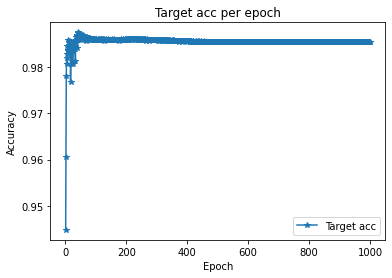

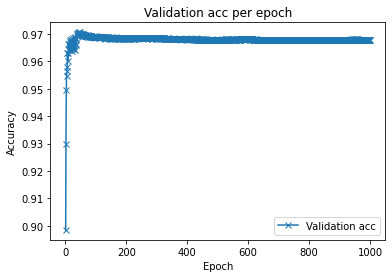

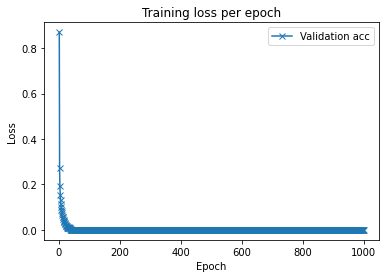

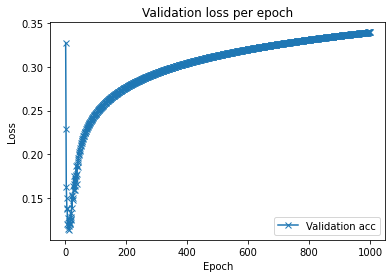

In [15]:
### test for MNIST-M-> MNIST
total_epochs=1000 #


iterations=5
histories=[]


    
histories=train_model(model="MNIST-M",total_epochs=total_epochs,x_train=x_train_m,y_train=y_train_m,x_test=x_test_m,y_test=y_test_m,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs)

Epoch 1/1000
469/469 [==============================] - 2s 4ms/step - loss: 0.7626 - accuracy: 0.7590 - val_loss: 0.0765 - val_accuracy: 0.9768
Epoch 2/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0925 - accuracy: 0.9720 - val_loss: 0.0515 - val_accuracy: 0.9837
Epoch 3/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.0386 - val_accuracy: 0.9885
Epoch 4/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0441 - accuracy: 0.9859 - val_loss: 0.0360 - val_accuracy: 0.9896
Epoch 5/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0370 - accuracy: 0.9887 - val_loss: 0.0336 - val_accuracy: 0.9886
Epoch 6/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0347 - accuracy: 0.9899 - val_loss: 0.0295 - val_accuracy: 0.9906
Epoch 7/1000
469/469 [==============================] - 2s 3ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0344 - val_accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 2.1656e-04 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9935
Epoch 58/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.4997e-04 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 0.9933
Epoch 59/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.2326e-04 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9935
Epoch 60/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8630e-04 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9933
Epoch 61/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.0296e-04 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9934
Epoch 62/1000
469/469 [==============================] - 2s 3ms/step - loss: 9.3386e-05 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9934
Epoch 63/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.3594e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 112/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4885e-05 - accuracy: 1.0000 - val_loss: 0.0378 - val_accuracy: 0.9931
Epoch 113/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7243e-05 - accuracy: 1.0000 - val_loss: 0.0381 - val_accuracy: 0.9933
Epoch 114/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.1708e-05 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9931
Epoch 115/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.8710e-05 - accuracy: 1.0000 - val_loss: 0.0381 - val_accuracy: 0.9933
Epoch 116/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.8891e-05 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9932
Epoch 117/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4699e-05 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9933
Epoch 118/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7189e-05 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.5901e-05 - accuracy: 1.0000 - val_loss: 0.0412 - val_accuracy: 0.9932
Epoch 167/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.4685e-05 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9932
Epoch 168/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5334e-05 - accuracy: 1.0000 - val_loss: 0.0410 - val_accuracy: 0.9931
Epoch 169/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6041e-05 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9932
Epoch 170/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5107e-05 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9932
Epoch 171/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5201e-05 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9931
Epoch 172/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.4941e-05 - accuracy: 1.0000 - val_l

Epoch 221/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.0223e-05 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9931
Epoch 222/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.1334e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9931
Epoch 223/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.0245e-05 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9931
Epoch 224/1000
469/469 [==============================] - 2s 3ms/step - loss: 9.8225e-06 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9931
Epoch 225/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.1835e-05 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9931
Epoch 226/1000
469/469 [==============================] - 2s 3ms/step - loss: 9.2633e-06 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9931
Epoch 227/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.1074e-05 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 8.1618e-06 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9931
Epoch 276/1000
469/469 [==============================] - 2s 3ms/step - loss: 7.3823e-06 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9931
Epoch 277/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.1428e-06 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9931
Epoch 278/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.1643e-06 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9931
Epoch 279/1000
469/469 [==============================] - 1s 3ms/step - loss: 7.5802e-06 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9931
Epoch 280/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.1795e-06 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9931
Epoch 281/1000
469/469 [==============================] - 2s 3ms/step - loss: 8.5800e-06 - accuracy: 1.0000 - val_l

Epoch 330/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.3586e-06 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9931
Epoch 331/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.0853e-06 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9931
Epoch 332/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.3861e-06 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9931
Epoch 333/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.0709e-06 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9931
Epoch 334/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.9989e-06 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9931
Epoch 335/1000
469/469 [==============================] - 2s 3ms/step - loss: 6.2219e-06 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9931
Epoch 336/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.9318e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 5.5517e-06 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9931
Epoch 385/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.6757e-06 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.9931
Epoch 386/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.9302e-06 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.9931
Epoch 387/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.3091e-06 - accuracy: 1.0000 - val_loss: 0.0469 - val_accuracy: 0.9931
Epoch 388/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.6175e-06 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9931
Epoch 389/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.9999e-06 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.9931
Epoch 390/1000
469/469 [==============================] - 2s 3ms/step - loss: 5.2446e-06 - accuracy: 1.0000 - val_l

Epoch 439/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.4381e-06 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 0.9931
Epoch 440/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.4943e-06 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9931
Epoch 441/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.7677e-06 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9931
Epoch 442/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.9774e-06 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 0.9931
Epoch 443/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.4353e-06 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9931
Epoch 444/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.3308e-06 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 0.9931
Epoch 445/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.5892e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 4.0134e-06 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9931
Epoch 494/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.7624e-06 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9931
Epoch 495/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.8835e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9931
Epoch 496/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.6323e-06 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9931
Epoch 497/1000
469/469 [==============================] - 2s 3ms/step - loss: 4.1286e-06 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9931
Epoch 498/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.9608e-06 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9931
Epoch 499/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.5809e-06 - accuracy: 1.0000 - val_l

Epoch 548/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2456e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 549/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2328e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 550/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.5184e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 551/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2651e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 552/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.1023e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 553/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.3729e-06 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 554/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.2720e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 3.1447e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 603/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.1520e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 604/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9470e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 605/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9839e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 606/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6973e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 607/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7960e-06 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9931
Epoch 608/1000
469/469 [==============================] - 2s 3ms/step - loss: 3.0648e-06 - accuracy: 1.0000 - val_l

Epoch 657/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.8021e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 658/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5637e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 659/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.6959e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 660/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.9926e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 661/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.7921e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 662/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5670e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9931
Epoch 663/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5001e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 2.3999e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 712/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3723e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 713/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2864e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 714/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4957e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 715/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5012e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 716/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.5377e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 717/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.4901e-06 - accuracy: 1.0000 - val_l

Epoch 766/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3563e-06 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9931
Epoch 767/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2332e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9931
Epoch 768/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3781e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9931
Epoch 769/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.3483e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9931
Epoch 770/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.1197e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9931
Epoch 771/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9953e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9931
Epoch 772/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2028e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.9748e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 821/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9447e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 822/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0787e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 823/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.0275e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 824/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8925e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 825/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.1399e-06 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9930
Epoch 826/1000
469/469 [==============================] - 2s 3ms/step - loss: 2.2117e-06 - accuracy: 1.0000 - val_l

Epoch 875/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8957e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 876/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8414e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 877/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9203e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 878/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9935e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 879/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8990e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 880/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8203e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9930
Epoch 881/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.9386e-06 - accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.9208e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 930/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7259e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 931/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8299e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 932/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6370e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 933/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6844e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 934/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7319e-06 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9930
Epoch 935/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5179e-06 - accuracy: 1.0000 - val_l

Epoch 984/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6609e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9930
Epoch 985/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5445e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9930
Epoch 986/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6682e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9930
Epoch 987/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.6630e-06 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9930
Epoch 988/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.8178e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9930
Epoch 989/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.7004e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9930
Epoch 990/1000
469/469 [==============================] - 2s 3ms/step - loss: 1.5767e-06 - accuracy:

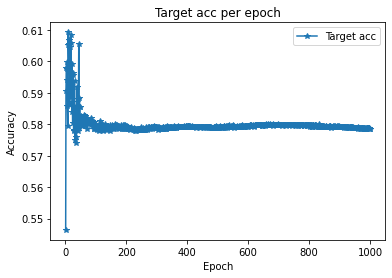

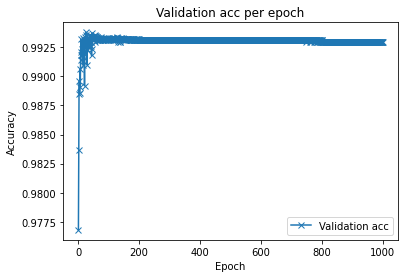

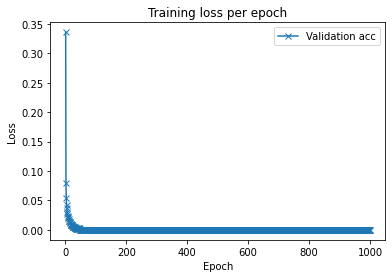

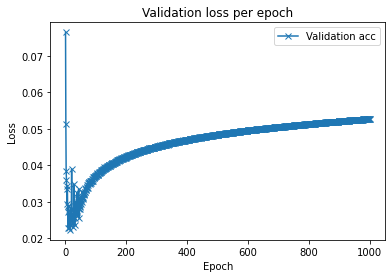

In [16]:
### test for MNIST-> MNIST-M
total_epochs=1000 #


iterations=5
histories=[]


    
histories=train_model(model="2MNIST-M",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=x_test_m,y_target=y_test_m)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="2MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs)

NameError: name 'x' is not defined

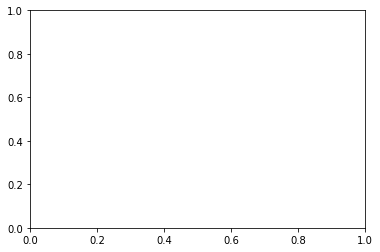

In [17]:
 ######## PLOTS for MNIST ############
f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNIST2SVHNval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNvalloss.pdf")


############SVHN PLOTS ############ 

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTvalloss.pdf")